<center>
    <h1><b>Deep Learning for Natural Language Processing<b></h1>
</center>

In this notebook we will develop a **sentiment classifier** on a given English-language **Twitter Dataset** containing some user comments. The main goal is to build a model that understands whether a specific comment has a **positive** sentiment or a **negative** sentiment.

## Data Preprocessing and Analysis

We will  begin by importing the **dataset** we are going to work with. The provided dataset consists of **3 CSV files** each one having its significant role in the process. We have the **training**, **validating** and **testing** files.
1. The training file is going to be used to train our model.
2. The validating file will tell us how good our model is by computing its accuracy.
3. The testing file is going to be used to test our model and extract some results and statistics.

Let's load our dataset files that are located in the `/Data/` directory.

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

dataset_base_filepath = '../Data/Raw' # "/kaggle/input/ai-2-deep-learning-for-nlp-homework-1"
images_base_filepath = '../imgs' # "/kaggle/input/images"

# Load all the dataset files using pandas and store inside some dataframe variables
train_df = pd.read_csv(f'{dataset_base_filepath}/train_dataset.csv')
val_df = pd.read_csv(f'{dataset_base_filepath}/val_dataset.csv')
test_df = pd.read_csv(f'{dataset_base_filepath}/test_dataset.csv')

# Reduce the data sizes
size=1
train_df = train_df.sample(frac=size)
val_df = val_df.sample(frac=size)
# test_df = test_df.sample(frac=size)

print(train_df.shape, val_df.shape, test_df.shape)

(148388, 3) (42396, 3) (21199, 2)


Let's take a look at some of the records of the training dataset.

In [2]:
train_df.head()

,ID,Text,Label
89312,137574,where'd all the sunshine go? It's pretty grim ...,0
71205,74147,@ashsimpsonwentz http://twitpic.com/2o6k7 - aw...,1
136824,195558,http://bit.ly/DZWW6 | O...o...oh. *reaches*,0
56975,18011,@CinemaChic,1
54716,99956,Thinking of having an early night with a good ...,0


### Data sizes

Let's have a look at the **sizes** of these datasets. In machine learning a **suitable size** of training, validating and testing data is around 70%, 20% and 10% respectively. 

Training Dataset size: 148388
Validating Dataset size: 42396
Testing Dataset size: 21199


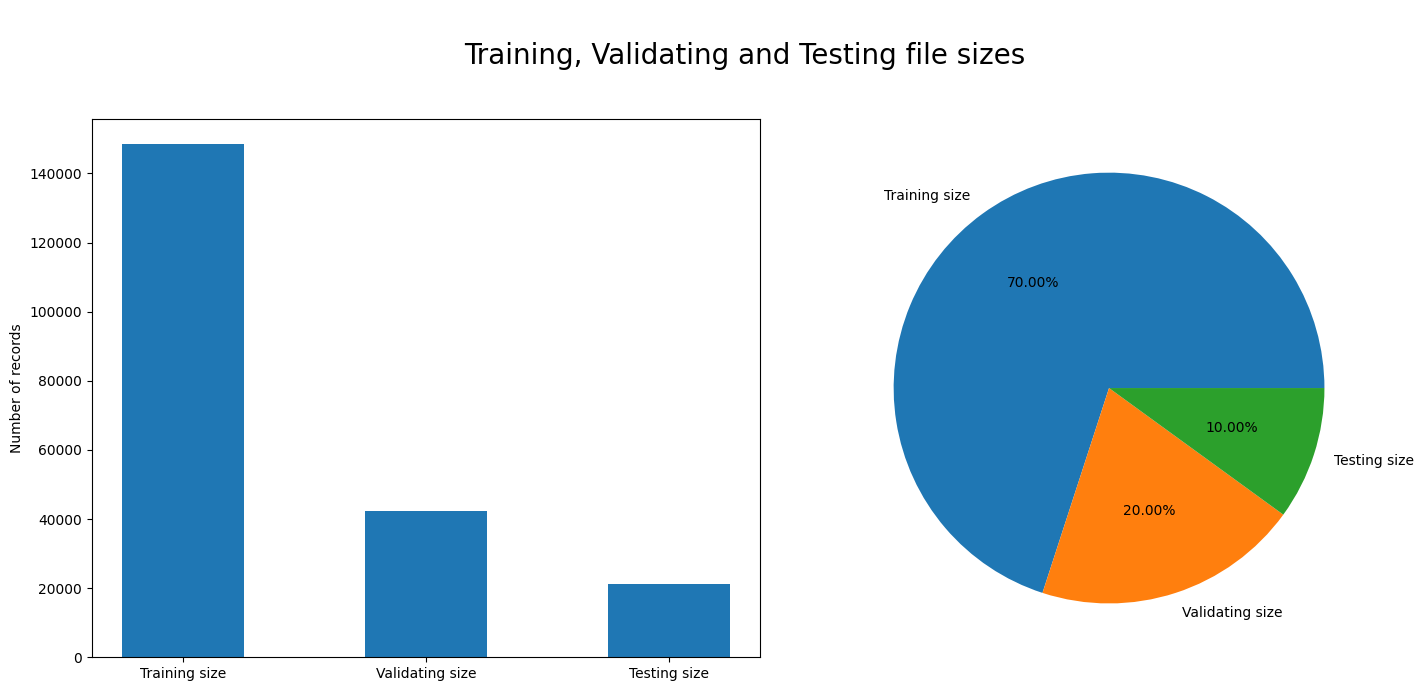

In [3]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

colors=['#99CCFF', '#C0DCFF', '#DAEDFF']

# Get the number of records for each dataset
train_size = train_df.shape[0]
val_size = val_df.shape[0]
test_size = test_df.shape[0]

print(f"Training Dataset size: {train_size}")
print(f"Validating Dataset size: {val_size}")
print(f"Testing Dataset size: {test_size}")

sizes = [train_size, val_size, test_size]
labels = ["Training size", "Validating size", "Testing size"]

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].bar(labels, sizes, width=0.5)
axes[0].set_ylabel("Number of records")

axes[1].pie(sizes, labels=labels, autopct="%1.2f%%")

plt.suptitle("\nTraining, Validating and Testing file sizes\n", fontsize=20)
plt.tight_layout()
plt.show()

From the results above we can easily tell that our dataset files satisfy the data splitting criterion.

### Processing and Cleaning

The first step of the whole process is to **pre-process** and **clean** our dataset files. In Machine Learning and AI applications, this is the initial and really important step. We will focus on
1. Transform shortcuts like **"I'm" to "I am"**.
2. Removing **URLs**, **User mentions**, **Hashtags** and **special characters**.
3. **Lowercasing** the texts
4. Removing **extra spaces**
5. Applying **stemming** and **lemmatization**

Let's begin by implementing a **function** that will handle the data pre-processing for a given string.

In [4]:
import os
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import contractions

nltk.download('wordnet')
nltk.download('omw-1.4')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

def clean_text(text: str) -> str:
    text = text.lower() # Convert to lowercase
    text = contractions.fix(text) # Expand contractions
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # Remove url links
    text = re.sub(r"@\w+", "", text) # Remove mentions
    text = re.sub(r"#(\w+)", "", text) # Remove hastags
    text = re.sub(r"(?<!\.)\.(?!\.)|[^\w\s\?\!]", "", text)
    text = re.sub(r"\.\.\.", " ... ", text)  # Ensure '...' is treated as a single token
    
    text = re.sub(r"&[^;\s]+;", "", text) # Remove special characters
    text = re.sub(r"\s+", " ", text) # Remove extra spaces
    
    text = re.sub(r"\d+", "", text)
    
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words] # Apply stemming
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words] # Apply lemmatization
    text = " ".join(lemmatized_words)
    
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Antonis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Antonis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Let's apply this function to the 3 dataset files, and see the results.

In [5]:
import time

# Apply the cleaning function to every dataset file and create a new column with the modified text
start_time = time.time()
train_df["Cleaned_text"] = train_df["Text"].apply(clean_text)
val_df["Cleaned_text"] = val_df["Text"].apply(clean_text)
test_df["Cleaned_text"] = test_df["Text"].apply(clean_text)
end_time = time.time()

print(f"Datasets were cleaned in {end_time - start_time} seconds.")

train_df.head(10)

Datasets were cleaned in 48.11149764060974 seconds.


,ID,Text,Label,Cleaned_text
89312,137574,where'd all the sunshine go? It's pretty grim ...,0,where did all the sunshin go? it is pretti gri...
71205,74147,@ashsimpsonwentz http://twitpic.com/2o6k7 - aw...,1,a you and peett so cute! i love couple!
136824,195558,http://bit.ly/DZWW6 | O...o...oh. *reaches*,0,oooh reach
56975,18011,@CinemaChic,1,
54716,99956,Thinking of having an early night with a good ...,0,think of have an earli night with a good book ...
5209,147884,told him how i feel now I'm sad and confused,0,told him how i feel now i am sad and confus
73470,89471,@saraxelizabeth and i cant wait to read your n...,1,and i cannot wait to read your novel
130430,115266,is finally up and still wondering why the gro...,0,is final up and still wonder whi the ground is...
4578,77252,wow i woke up mad early!! now idk what to do ...,0,wow i woke up mad early!! now i do not know wh...
43010,159912,@Kishiyaya @lovehound @StewartWade @loganX2 @t...,0,damnit is it doodl time again?! feel quizzi al...


We will now proceed to **analyze** the **training dataset**. We are going to focus on the **words** of each tweet and extract the most frequent ones, by generating a **Word Cloud** and a **Bar Plot**.

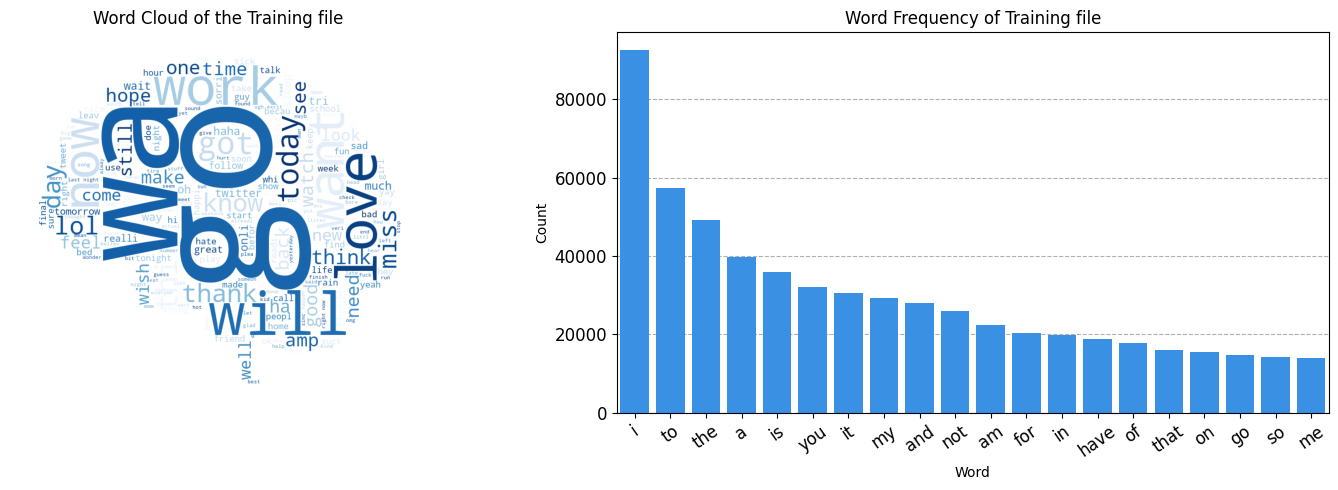

In [6]:
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import numpy as np
import PIL.Image

brain_mask = np.array(PIL.Image.open(images_base_filepath + "/brain_logo.jpg"))

def analize_words(df: pd.DataFrame, column: str, bar_color="#7AC2FF"):
    all_text = " ".join(df[column])
    all_words = " ".join(df[column]).split()
    
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(20)
    
    common_df = pd.DataFrame(most_common_words, columns=["Word", "Count"])
    
    wordcloud = WordCloud(width=800, height=800, background_color="#FFF", colormap="Blues", mask=brain_mask)
    wordcloud.generate(all_text)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(wordcloud)
    axes[0].axis("off")
    axes[0].set_title("Word Cloud of the Training file")
    
    axes[1].set_axisbelow(True)
    axes[1].grid(zorder=1, linestyle='dashed')
    bars = sns.barplot(x="Word", y="Count", data=common_df, color=bar_color, ax=axes[1])
    
    axes[1].set_title("Word Frequency of Training file")
    axes[1].set_xticklabels(labels=common_df["Word"], rotation=35, fontsize=10)
    axes[1].tick_params(axis="both", which="major", labelsize=12)
    
    # plt.savefig(filename)
    plt.tight_layout()
    plt.show()

analize_words(train_df, column='Cleaned_text', bar_color='dodgerblue')

The above graphs reveal to us the frequency of some words inside the dataset. The plot on the right appears to have words that are not practically useful. These words are called **stopwords** and the `wordcloud` Python package automatically ignores them. That's because we have different results on the left and right plots. Having stopwords in our dataset is not a good practice for sentiment analysis because stopwords do not add much meaning. So we will take care of them by removing them from the dataset.

In [7]:
import nltk
from nltk import data
from nltk.tokenize import word_tokenize
import time

warnings.filterwarnings("ignore", category=UserWarning, module="nltk")

def remove_stopwords(text: str) -> str:
    # Remove the stopwords from the original text
    stop_words = set(
        ["i", "to", "the", "is", "a", "you", "my", "and", 
         "it", "am", "for", "in", "of", "that", "on", "so", "me"]
    )
    word_tokens = word_tokenize(text)
    filtered_words = [word for word in word_tokens if word not in stop_words]

    return " ".join(filtered_words)

start_time = time.time()
train_df['Cleaned_text'] = train_df['Cleaned_text'].apply(remove_stopwords)
val_df['Cleaned_text'] = val_df['Cleaned_text'].apply(remove_stopwords)
test_df['Cleaned_text'] = test_df['Cleaned_text'].apply(remove_stopwords)
end_time = time.time()


print(f"Stopwords were removed in {end_time - start_time} seconds.")

Stopwords were removed in 18.541858196258545 seconds.


By executing the code above we must have removed some useless stopwords from the dataset. Let's have a look at the dataset and the analytics one more time.

In [8]:
train_df.head(10)

,ID,Text,Label,Cleaned_text
89312,137574,where'd all the sunshine go? It's pretty grim ...,0,where did all sunshin go ? pretti grim out the...
71205,74147,@ashsimpsonwentz http://twitpic.com/2o6k7 - aw...,1,peett cute ! love couple !
136824,195558,http://bit.ly/DZWW6 | O...o...oh. *reaches*,0,oooh reach
56975,18011,@CinemaChic,1,
54716,99956,Thinking of having an early night with a good ...,0,think have an earli night with good book but h...
5209,147884,told him how i feel now I'm sad and confused,0,told him how feel now sad confus
73470,89471,@saraxelizabeth and i cant wait to read your n...,1,can not wait read your novel
130430,115266,is finally up and still wondering why the gro...,0,final up still wonder whi ground not move unde...
4578,77252,wow i woke up mad early!! now idk what to do ...,0,wow woke up mad early ! ! now do not know what...
43010,159912,@Kishiyaya @lovehound @StewartWade @loganX2 @t...,0,damnit doodl time again ? ! feel quizzi alread...


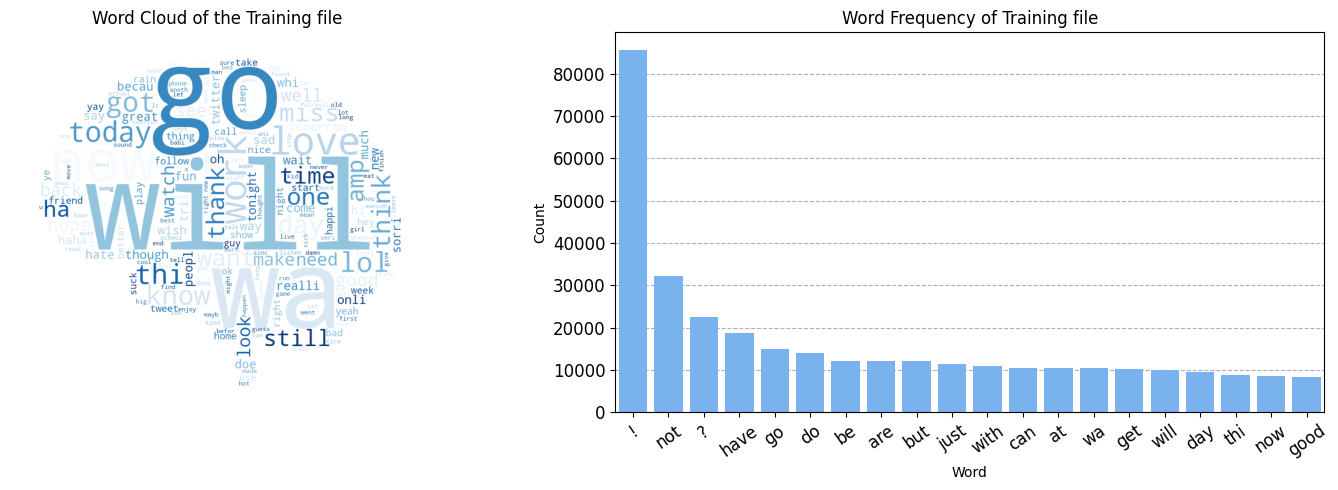

In [9]:
analize_words(train_df, column='Cleaned_text', bar_color="#66B2FF")

As we expected all the common stopwords like 'I', 'the', 'so' and more have been deleted from the records of the dataset. As we can see the dataset has been cleaned successfully and there not any stopwords in the records.

### Exploratory Data Analysis (EDA)

We are now going to fall into a deeper analysis of the dataset, in order to collect some information about the user comments.

### Text Length Analysis
We will start by analizing the **length** of the tweets in both training and validation files. Specifically will perform a **Tweet Length Distribution** and a **Comparison between sentiments**. 

#### Tweet Length DIstribution

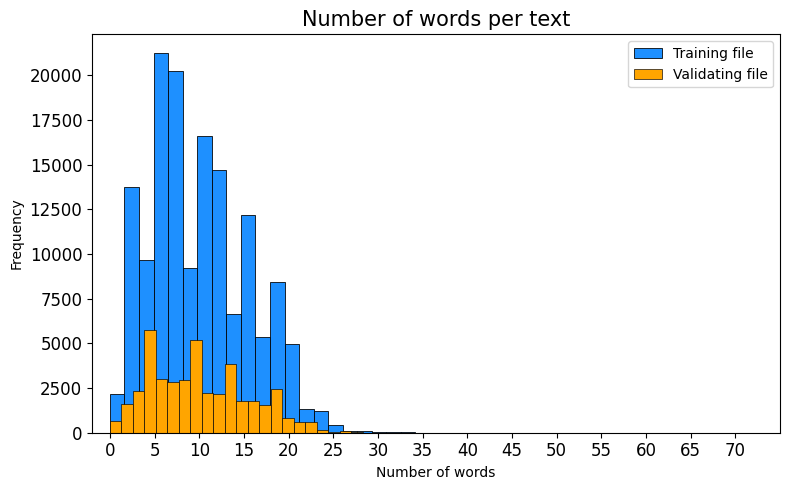

In [10]:
import seaborn as sns


train_df['num_words'] = train_df['Cleaned_text'].apply(lambda x: len(x.split()))
val_df['num_words'] = val_df['Cleaned_text'].apply(lambda x: len(x.split()))

# Plot the histogram of the number of words in the training and validating files
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(train_df['num_words'], bins=70, color='dodgerblue', label='Training file', ax=ax, alpha=1)
sns.histplot(val_df['num_words'], bins=70, color='orange', label='Validating file', ax=ax, alpha=1)

ax.set_xlabel("Number of words")
ax.set_ylabel("Frequency")
ax.legend()

ax.set_xlim(-2, 75)
ax.set_xticks(range(0, 75, 5))
ax.tick_params(axis='both', which='major', labelsize=12)

plt.title("Number of words per text", fontsize=15)
plt.tight_layout()
plt.show()


#### Comparison between Sentiment

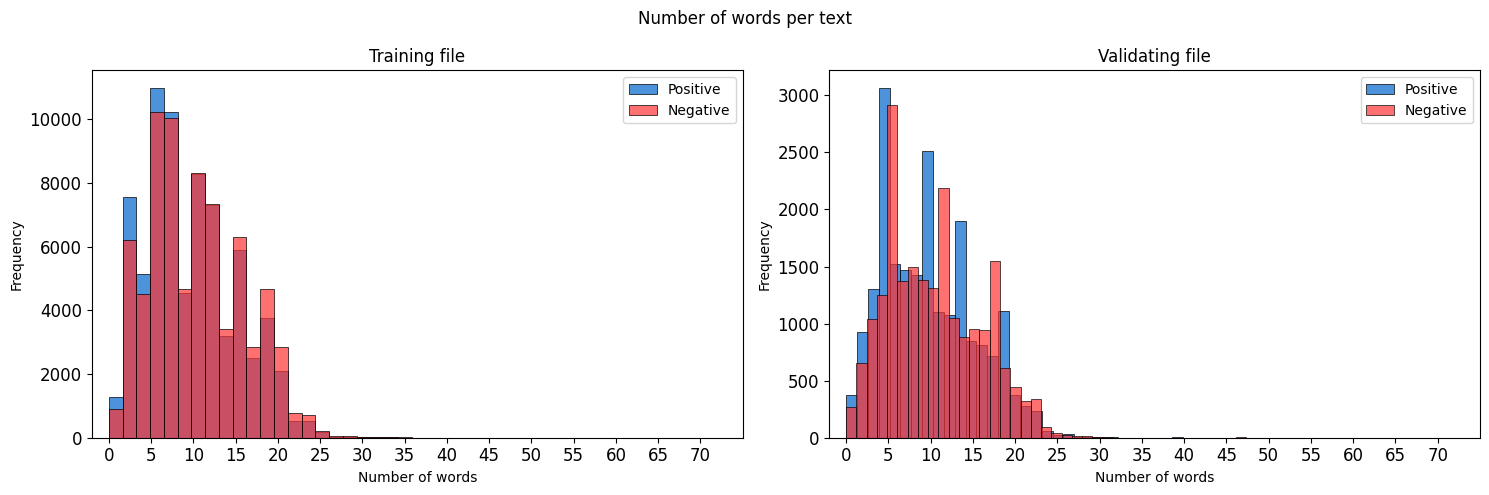

In [11]:
# Compare words frequency between positive and negative tweets
positive_train_df = train_df[train_df['Label'] == 1]
negative_train_df = train_df[train_df['Label'] == 0]

positive_val_df = val_df[val_df['Label'] == 1]
negative_val_df = val_df[val_df['Label'] == 0]

# Plot the word frequency of positive and negative tweets for the training and validating files
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(positive_train_df['num_words'], bins=70, color='#0066CC', label='Positive', ax=axes[0], alpha=0.7)
sns.histplot(negative_train_df['num_words'], bins=70, color='#FF3333', label='Negative', ax=axes[0], alpha=0.7)

sns.histplot(positive_val_df['num_words'], bins=70, color='#0066CC', label='Positive', ax=axes[1], alpha=0.7)
sns.histplot(negative_val_df['num_words'], bins=70, color='#FF3333', label='Negative', ax=axes[1], alpha=0.7)

axes[0].set_title("Training file")
axes[1].set_title("Validating file")

for ax in axes:
    ax.set_xlabel("Number of words")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.set_xlim(-2, 75)
    ax.set_xticks(range(0, 75, 5))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
plt.suptitle("Number of words per text")
plt.tight_layout()
plt.show()

### Sentiment Distribution Analysis

Then we will attempt to do a **sentiment distribution analsysis** to training and validating dataset files. Specifically we will count the number of tweets for each sentiment in both training and validating files.

In [12]:
def get_sentiment_distribution(df: pd.DataFrame) -> tuple[int, int]:
    positive_count, negative_count = 0, 0
    for label in df['Label']:
        if label == 1: positive_count += 1
        else: negative_count += 1

    return positive_count, negative_count

Training file has 74196 positive tweets and 74192 negative tweets
Validating file has 21199 positive tweets and 21197 negative tweets


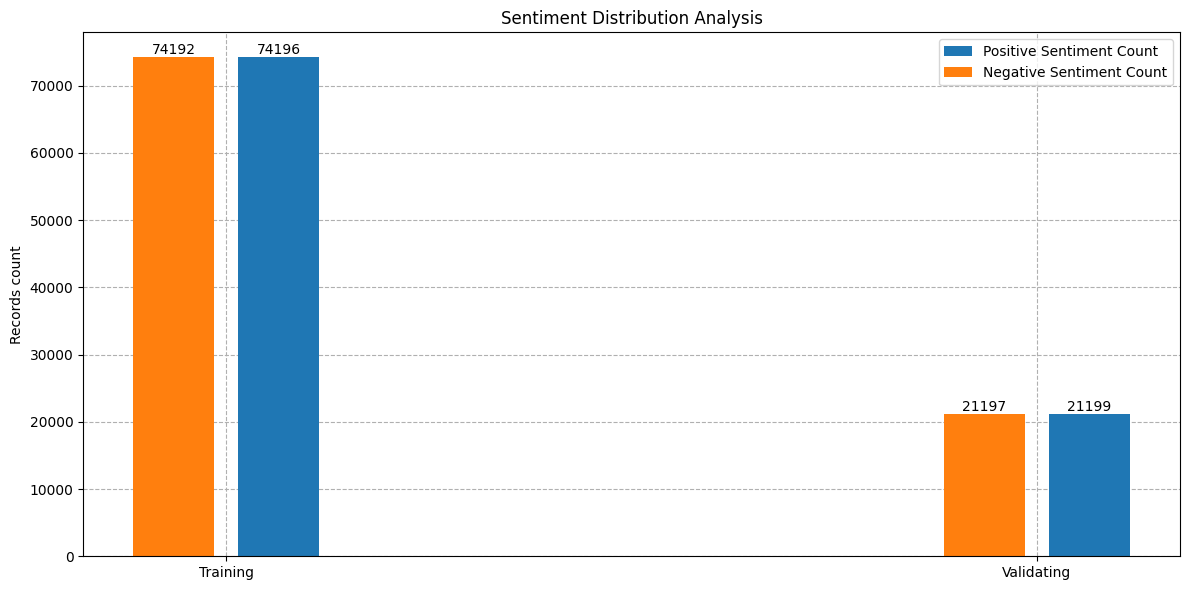

In [13]:
import numpy as np

# Get the sentiment distribution analysis of training and validating files
train_sent_dist = get_sentiment_distribution(train_df)
val_sent_dist = get_sentiment_distribution(val_df)

print(f"Training file has {train_sent_dist[0]} positive tweets and {train_sent_dist[1]} negative tweets")
print(f"Validating file has {val_sent_dist[0]} positive tweets and {val_sent_dist[1]} negative tweets")

files_labels = ["Training", "Validating"]

bar_width = 0.10
gap = 0.015

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_axisbelow(True)
ax.grid(zorder=1, linestyle='dashed')
positive_bar = ax.bar(
    np.arange(len(files_labels)) + bar_width/2+gap, 
    [train_sent_dist[0], val_sent_dist[0]], 
    width=bar_width, 
    label='Positive Sentiment Count'
)

negative_bar = ax.bar(
    np.arange(len(files_labels)) - bar_width/2-gap, 
    [train_sent_dist[1], val_sent_dist[1]], 
    width=bar_width, 
    label='Negative Sentiment Count'
)

ax.bar_label(positive_bar, label_type='edge')
ax.bar_label(negative_bar, label_type='edge')

ax.set_title('Sentiment Distribution Analysis')
ax.set_ylabel('Records count')

ax.set_xticks(np.arange(len(files_labels)))
ax.set_xticklabels(files_labels)

plt.legend()
plt.tight_layout()

# plt.savefig('../plots/dataset_sentiment_distribution.png')
plt.show()

As we can see the number of positive and negative tweets inside the training and validating dataset files are **almost equal**. In both files the positive tweets prevail over the negative ones. Generally we can say that the dataset is **balanced**.

### Generalized diagram

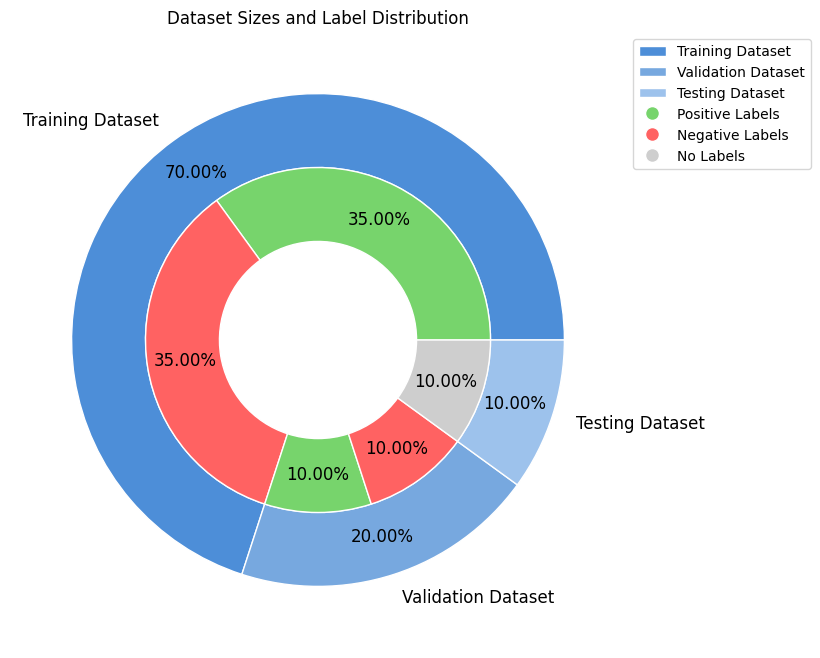

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset names
datasets = ['Training Dataset', 'Validation Dataset', 'Testing Dataset']

# Total dataset sizes
total_sizes = np.array([train_df.shape[0], val_df.shape[0], test_df.shape[0]])

# Positive and Negative label counts (for Training and Validation datasets)
pos_counts = np.array(
    [train_df[train_df['Label'] == 1].shape[0], 
     val_df[val_df['Label'] == 1].shape[0], 0]
)

neg_counts = np.array(
    [train_df[train_df['Label'] == 0].shape[0], 
     val_df[val_df['Label'] == 0].shape[0], 0]
) 

# Define outer ring (total dataset sizes)
outer_sizes = total_sizes
outer_labels = datasets
outer_colors = ['#4D8ED8', '#77A8DF', '#9DC2EC']

# Define inner ring (label distribution)
inner_sizes = []
inner_colors = []
legend_labels = []  # Used for a separate legend

for i in range(len(datasets)):
    if pos_counts[i] > 0 or neg_counts[i] > 0:
        inner_sizes.extend([pos_counts[i], neg_counts[i]])
        inner_colors.extend(["#77D46C", "#FF6262"])  # Green for positive, red for negative
    else:
        inner_sizes.append(total_sizes[i])  # No labels
        inner_colors.append("#CECECE")  # Gray for unlabeled data

fig, ax = plt.subplots(figsize=(8, 8))

# Function to manually compute and display correct percentages
def correct_autopct(pct, values):
    absolute = int(round(pct / 100. * np.sum(values)))  # Convert percent to actual count
    true_pct = absolute / np.sum(values) * 100  # Compute correct percentage
    return f"{true_pct:.2f}%" if absolute > 0 else ""  # Hide zero values

# Outer pie (Total dataset sizes) with percentages
outer_patches, outer_texts, outer_autotexts = ax.pie(
    outer_sizes, labels=outer_labels, colors=outer_colors, radius=1, 
    wedgeprops=dict(width=0.3, edgecolor='w'), autopct=lambda pct: correct_autopct(pct, outer_sizes), 
    textprops={'fontsize': 12}
)

# Inner pie (Label distribution) with percentages
inner_patches, inner_texts, inner_autotexts = ax.pie(
    inner_sizes, colors=inner_colors, radius=0.7,
    wedgeprops=dict(width=0.3, edgecolor='w'), autopct=lambda pct: correct_autopct(pct, inner_sizes), 
    textprops={'fontsize': 12}
)

# Adjust the percentage label positions to move them slightly outward
for autotext in outer_autotexts:
    x, y = autotext.get_position()
    autotext.set_position((x * 1.4, y * 1.4))  # Move outward

for autotext in inner_autotexts:
    x, y = autotext.get_position()
    autotext.set_position((x * 1.3, y * 1.3))  # Move further outward for inner pie

# Create legend manually (only unique "Positive" and "Negative" labels)
legend_patches = outer_patches  # Only dataset labels initially
legend_labels = outer_labels  # Only dataset names initially

# Add a single entry for "Positive" and "Negative"
positive_patch = plt.Line2D(
    [0], [0], marker='o', color='w', markersize=10, 
    markerfacecolor='#77D46C', label="Positive Labels"
)
negative_patch = plt.Line2D(
    [0], [0], marker='o', color='w', markersize=10, 
    markerfacecolor='#FF6262', label="Negative Labels"
)
no_label_patch = plt.Line2D(
    [0], [0], marker='o', color='w', markersize=10, 
    markerfacecolor='#CECECE', label="No Labels"
)

# Extend the legend with "Positive" and "Negative" colors
legend_patches.extend([positive_patch, negative_patch, no_label_patch])
legend_labels.extend(["Positive Labels", "Negative Labels", "No Labels"])

ax.legend(handles=legend_patches, labels=legend_labels, loc="upper left", bbox_to_anchor=(1, 1))

# Title
plt.title("Dataset Sizes and Label Distribution")
plt.show()


### Sentiment Correlation

Finally we will do some **sentiment correlation** with **specific words**. In other words we will identify the words that are highly correlated with a specific sentiment. Let's begin by splitting the training dataset into two data frames containing all the positive and negative tweets.

In [15]:
train_positive_df = train_df[train_df['Label'] == 1]
train_negative_df = train_df[train_df['Label'] == 0]

In [16]:
train_positive_df.head()

,ID,Text,Label,Cleaned_text,num_words
71205,74147,@ashsimpsonwentz http://twitpic.com/2o6k7 - aw...,1,peett cute ! love couple !,6
56975,18011,@CinemaChic,1,,0
73470,89471,@saraxelizabeth and i cant wait to read your n...,1,can not wait read your novel,6
98929,18362,@sleepydumpling can't this morning I'm having ...,1,can not thi morn have breakfast with ladyfriend,8
97118,107708,on thee phone with makk watchingg george lope...,1,thee phone with makk watchingg georg lopezz bb...,18


In [17]:
train_negative_df.head()

,ID,Text,Label,Cleaned_text,num_words
89312,137574,where'd all the sunshine go? It's pretty grim ...,0,where did all sunshin go ? pretti grim out the...,11
136824,195558,http://bit.ly/DZWW6 | O...o...oh. *reaches*,0,oooh reach,2
54716,99956,Thinking of having an early night with a good ...,0,think have an earli night with good book but h...,15
5209,147884,told him how i feel now I'm sad and confused,0,told him how feel now sad confus,7
130430,115266,is finally up and still wondering why the gro...,0,final up still wonder whi ground not move unde...,12


Let's find and plot the **30 most common** words in each data frame.

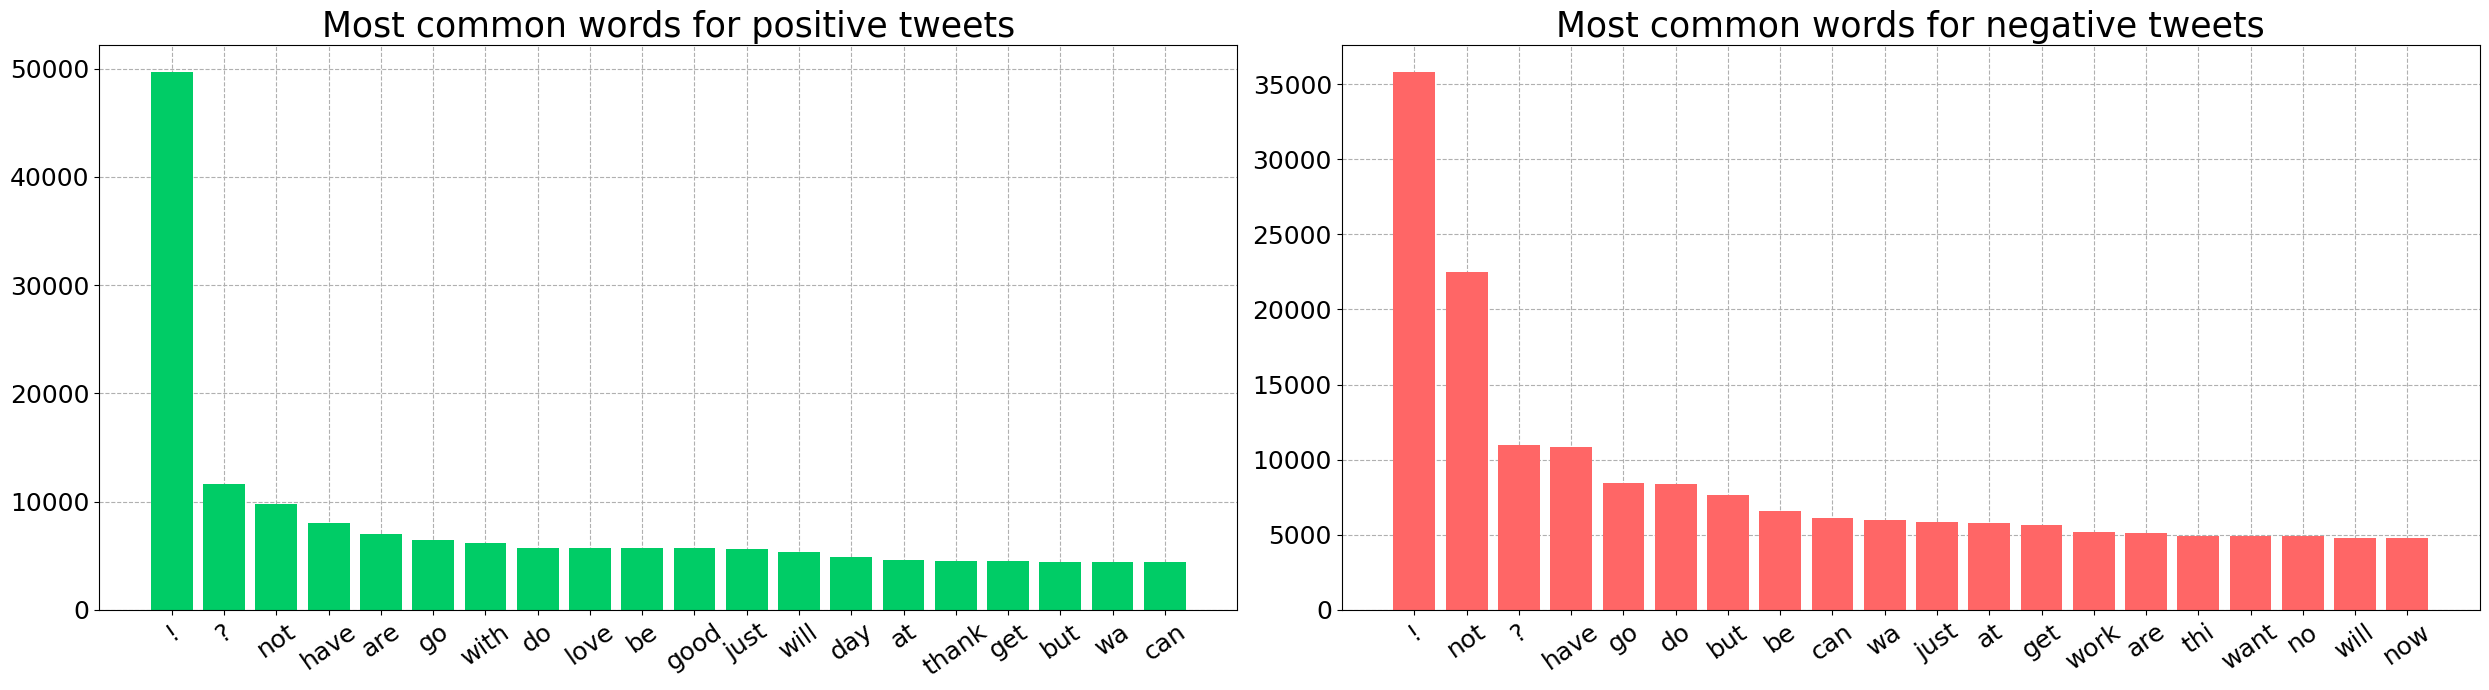

In [18]:
from collections import Counter

# Receive all the words from the positive dataframe
all_train_positive_text = " ".join(train_positive_df['Cleaned_text'])
all_train_positive_words = all_train_positive_text.split()

# Find the most common words
train_positive_words_counter = Counter(all_train_positive_words)
most_common_train_positive_words = train_positive_words_counter.most_common(20)

# Receive all the words from the negative dataframe
all_train_negative_text = " ".join(train_negative_df['Cleaned_text'])
all_train_negative_words = all_train_negative_text.split()

# Find the most common words
train_negative_words_counter = Counter(all_train_negative_words)
most_common_train_negative_words = train_negative_words_counter.most_common(20)

# Plot the data
positive_labels = [word[0] for word in most_common_train_positive_words]
positive_count = [word[1] for word in most_common_train_positive_words]

negative_labels = [word[0] for word in most_common_train_negative_words]
negative_count = [word[1] for word in most_common_train_negative_words]

fig, axes = plt.subplots(1, 2, figsize=(25, 7))
axes[0].set_axisbelow(True)
axes[0].grid(zorder=1, linestyle='dashed')
axes[0].bar(positive_labels, positive_count, color="#00CC66")
axes[0].set_title('Most common words for positive tweets', fontsize=25)
axes[0].set_xticklabels(labels=positive_labels, rotation=35, fontsize=15)
axes[0].tick_params(axis='both', which='major', labelsize=18)

axes[1].set_axisbelow(True)
axes[1].grid(zorder=1, linestyle='dashed')
axes[1].bar(negative_labels, negative_count, color="#FF6666")
axes[1].set_title('Most common words for negative tweets', fontsize=25)
axes[1].set_xticklabels(labels=negative_labels, rotation=35, fontsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=18)

# plt.savefig('../plots/most_common_words.png')
plt.tight_layout()
plt.show()

### Comparative Analysis of Word Frequencies by Sentiment

In [19]:
from collections import defaultdict

def get_top_words(text_series, n=10):
    all_words = ' '.join(text_series).split()
    all_words = sorted(Counter(all_words).most_common(n), key=lambda x: x[1], reverse=True)
    return [pair[0] for pair in all_words]
    
def word_frequency_by_sentiment(df, words_list, text_col='Cleaned_text', label_col='Label'):
    # Initialize results
    freq_dict = defaultdict(lambda: {'positive': 0, 'negative': 0, 'total': 0})
    
    # Count word occurrences
    for word in words_list:
        for _, row in df.iterrows():
            if word in row[text_col].split():
                sentiment = 'positive' if row[label_col] == 1 else 'negative'
                freq_dict[word][sentiment] += 1
                freq_dict[word]['total'] += 1
    
    # Convert to DataFrame
    result_df = pd.DataFrame.from_dict(freq_dict, orient='index')
    result_df.index.name = 'word'
    return result_df.sort_values(by='total', ascending=False)
    
top_words = get_top_words(train_df['Cleaned_text'], n=20)
result_df = word_frequency_by_sentiment(train_df, top_words)

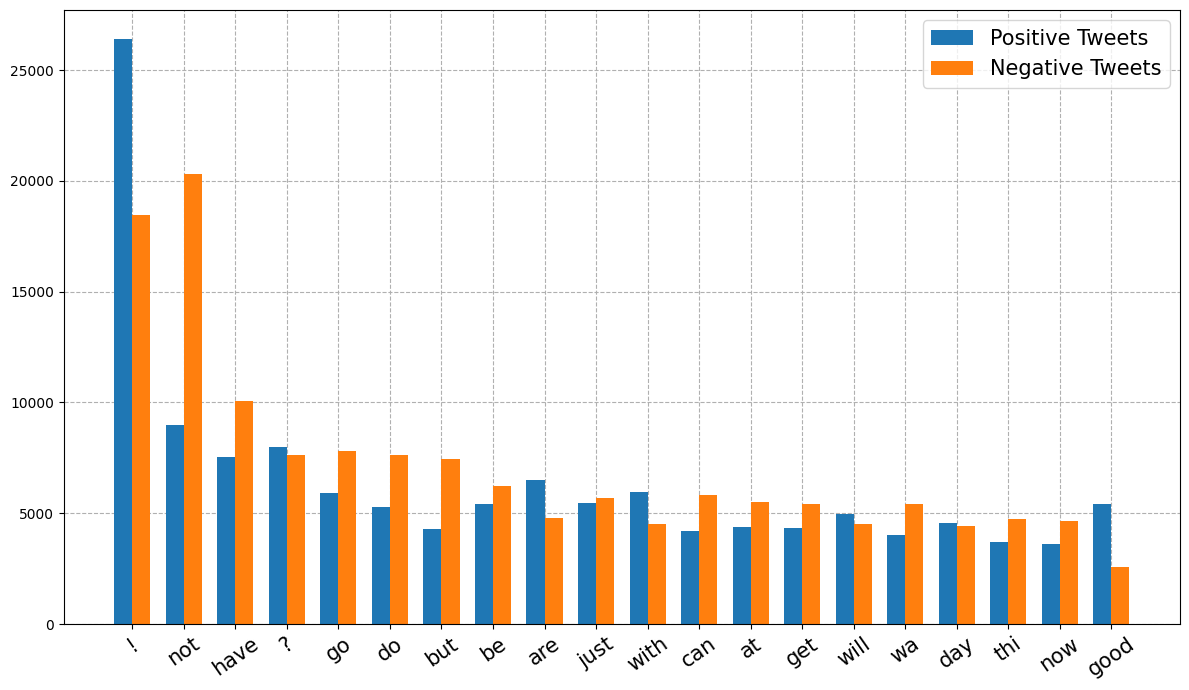

In [20]:
labels = list(result_df.index)
X_axis = np.arange(len(labels))

bar_width = 0.35
gap = bar_width / 2

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.set_axisbelow(True)
ax.grid(zorder=1, linestyle='dashed')
ax.bar(X_axis - gap, result_df['positive'], bar_width, label='Positive Tweets')
ax.bar(X_axis + gap, result_df['negative'], bar_width, label='Negative Tweets')

ax.set_xticks(X_axis, labels, rotation=35, fontsize=15)

plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

## Model Training and Evaluation

We will now perform the **training process** of the model. We will start by initializing the **TF-IDF** vectorizer.

In [21]:
train_df

,ID,Text,Label,Cleaned_text,num_words
89312,137574,where'd all the sunshine go? It's pretty grim ...,0,where did all sunshin go ? pretti grim out the...,11
71205,74147,@ashsimpsonwentz http://twitpic.com/2o6k7 - aw...,1,peett cute ! love couple !,6
136824,195558,http://bit.ly/DZWW6 | O...o...oh. *reaches*,0,oooh reach,2
56975,18011,@CinemaChic,1,,0
54716,99956,Thinking of having an early night with a good ...,0,think have an earli night with good book but h...,15
...,...,...,...,...,...
123223,139582,hi twitter ive missed you. trucco for breakfa...,1,hi twitter have miss trucco breakfast then sle...,12
89843,187092,@CyndiSabine Thanks for the shoutout and the k...,1,thank shoutout kind words !,5
130619,112456,@yoha_ahoy yeah I really want one too! Probab...,0,yeah realli want one too ! probabl winter may ...,16
142272,164040,39 degrees of fever and raising... damm... I n...,0,degre fever rais damm need finish thi report,8


### Vectorizing the data
We will start by **vectorizing** our data. We will define a function where it's going to take the **maximum features** and the **range of the ngrams**. In this way we can later execute some experiments with different values of these parameters.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_data(train_df, val_df, test_df, max_features=100000, ngram_range=(1,4)):
    if max_features is None and ngram_range is None:
        vectorizer = TfidfVectorizer()
    elif max_features is not None and ngram_range is None:
        vectorizer = TfidfVectorizer(
            max_features=max_features
        )
    elif max_features is None and ngram_range is not None:
        vectorizer = TfidfVectorizer(
            ngram_range=ngram_range
        )
    else:
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range
        )

    X_train = vectorizer.fit_transform(train_df['Cleaned_text'])
    X_val = vectorizer.transform(val_df['Cleaned_text'])
    X_test = vectorizer.transform(test_df['Cleaned_text'])
    
    y_train = train_df['Label']
    y_val = val_df['Label']

    return X_train, X_val, X_test, y_train, y_val, vectorizer

Let's try to vectorize our data with the **default parameters** at first.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load the data and vectorize them using TF-IDF method
X_train, X_val, X_test, y_train, y_val, vectorizer = vectorize_data(train_df, val_df, test_df, None, None)
print(X_train.shape, X_val.shape)

(148388, 72713) (42396, 72713)


Our result matrices are $148388 \times 72713$, and $42396 \times 72713$ individualy, on which the rows represent the documents and the columns represent the words.

### Data Visualization with PCA

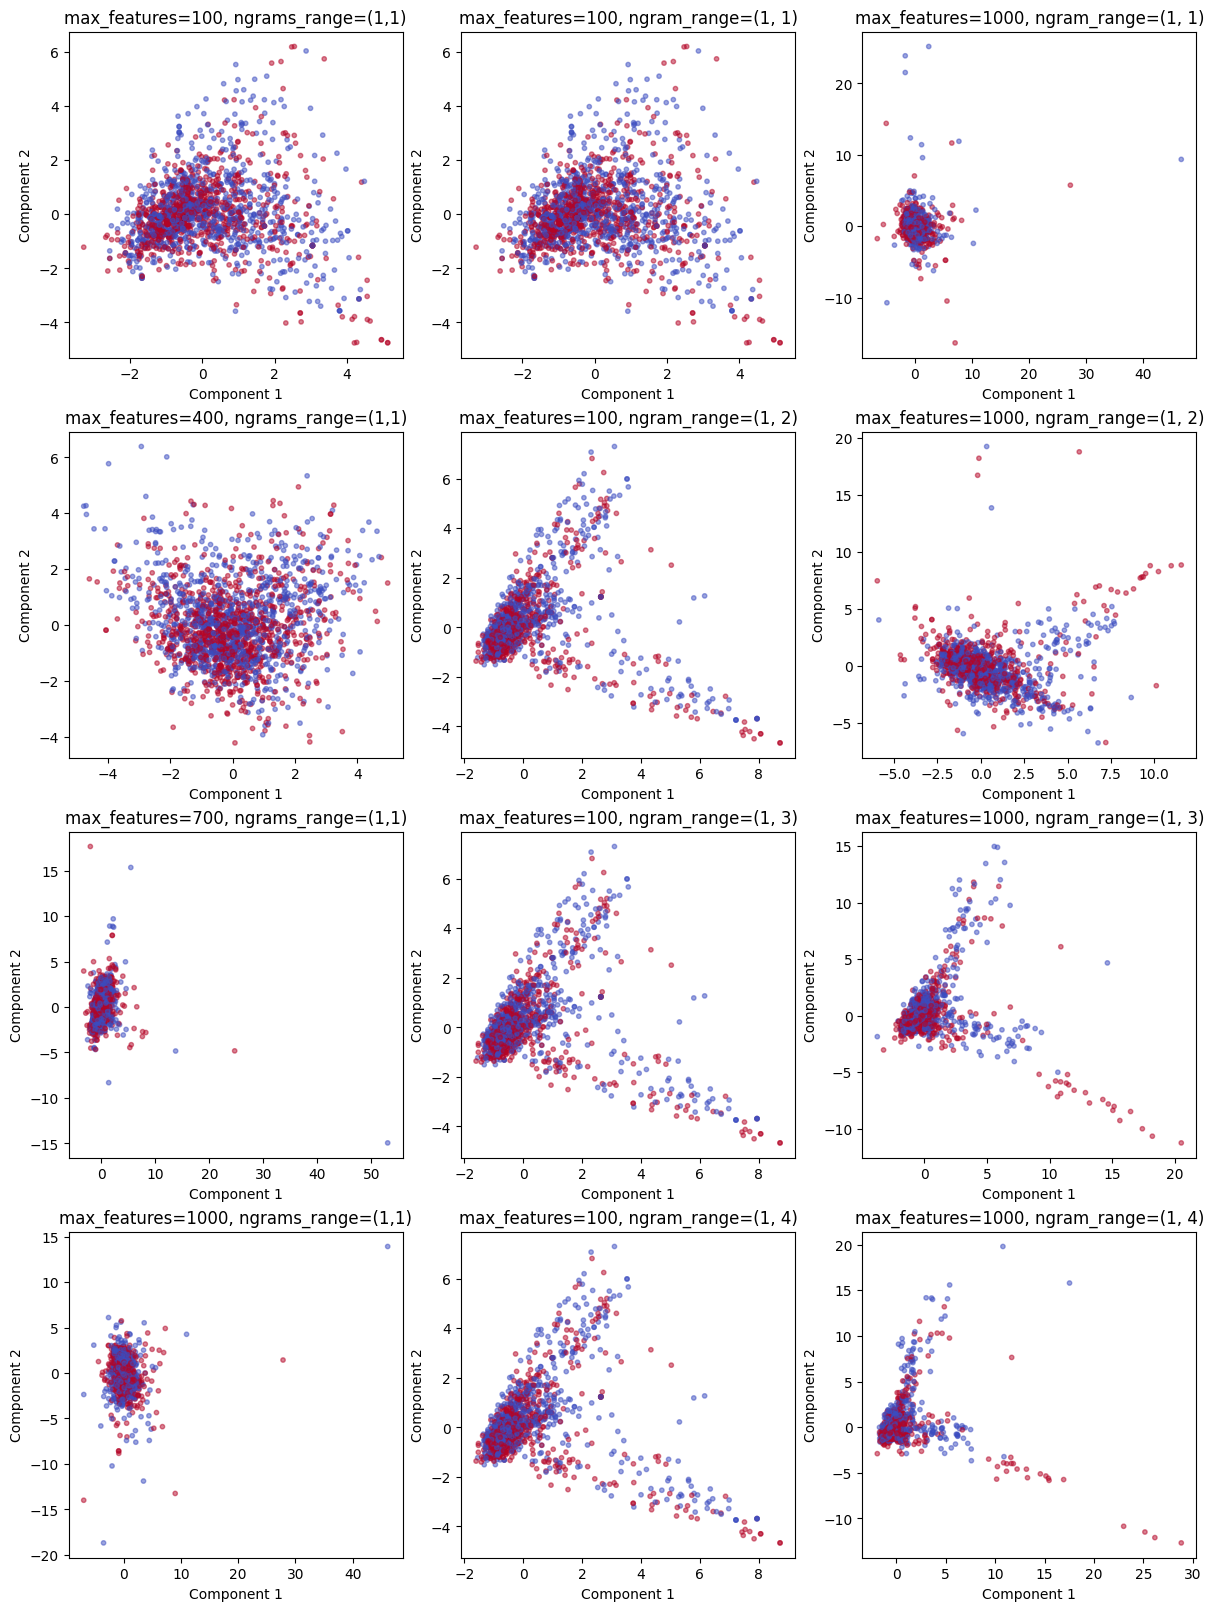

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def visualize_pca_2d(X_train, y_train, sample_size=2000, ax=None, title=""):
    # Convert sparse matrix to dense array if needed
    if hasattr(X_train, "toarray"):
        X_train = X_train[:sample_size].toarray()
    
    # Standardize the data
    scaler = StandardScaler(with_mean=False)
    X_train_scaled = scaler.fit_transform(X_train)

    # Apply PCA
    pca_2d = PCA(n_components=2)
    X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)

    # 2D PCA plot
    scatter = ax.scatter(
        X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train[:sample_size], 
        s=10, cmap='coolwarm', alpha=0.5
    )
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(title, fontsize=12)
    return scatter

# Define the range of max_features and ngrams_range
rows = 4
max_features_values = np.linspace(100, 1_000, rows, dtype=int)
ngrams_range_values = np.linspace(1, rows, rows, dtype=int)

# Create subplots
fig, axes = plt.subplots(len(max_features_values), 3, figsize=(12, 16), constrained_layout=True)

# Visualize PCA for different max_features
for i, max_features in enumerate(max_features_values):
    X, _, _, y, _, _ = vectorize_data(train_df, val_df, test_df, max_features, (1,1))
    scatter = visualize_pca_2d(X, y, ax=axes[i, 0], title=f"max_features={max_features}, ngrams_range=(1,1)")

# Visualize PCA for different ngram ranges
for i, ngrams_range_value in enumerate(ngrams_range_values):
    X, _, _, y, _, _ = vectorize_data(train_df, val_df, test_df, 100, (1, ngrams_range_value))
    scatter = visualize_pca_2d(X, y, ax=axes[i, 1], title=f"max_features=100, ngram_range=(1, {ngrams_range_value})")
    
for i, ngrams_range_value in enumerate(ngrams_range_values):
    X, _, _, y, _, _ = vectorize_data(train_df, val_df, test_df, 1000, (1, ngrams_range_value))
    scatter = visualize_pca_2d(X, y, ax=axes[i, 2], title=f"max_features=1000, ngram_range=(1, {ngrams_range_value})")

plt.show()

### Default Prediction
We will start by executing a default (dummy) prediction on our **validation data** without having a trained model.

In [25]:
batch_size = 1000  

weights, bias = np.random.randn(X_val.shape[1], 1), np.random.randn()
y_pred = np.zeros((X_val.shape[0], 1))  # Placeholder for predictions

# Use batches for faster calculation
for i in range(0, X_val.shape[0], batch_size):
    batch_end = i + batch_size
    y_pred[i:batch_end] = X_val[i:batch_end] @ weights + bias

y_pred = np.where(y_pred >= 0.5, 1, 0)
accuracy = accuracy_score(y_val, y_pred)
print(f"Default Accuracy: {accuracy}")

Default Accuracy: 0.49629682045475987


As we can see a random default prediction gives an **accuracy** of about **0.5**. That is logical to happen due to the fact that the datasets are **balanced** as we saw previously.

### Custom Gradient Descent

In [26]:
from scipy.special import expit as sigmoid
from sklearn.utils import shuffle

def cross_entropy_loss(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return -np.mean(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))

def compute_gradient(X, y, y_pred):
    m = X.shape[0]
    dw = (1 / m) * (X.T @ (y_pred - y))
    db = (1 / m) * np.sum(y_pred - y)
    return dw, db

def GradientDescent(X, y, X_val, y_val, learning_rate, max_epochs, batch_size, print_progress=True):
    m, n = X.shape
    W, b = np.zeros((n, 1)), 0
    
    train_losses, train_accuracies, val_accuracies = [], [], []
    
    for epoch in range(max_epochs+1):
        # Shuffle data each epoch
        X, y = shuffle(X, y)
        epoch_loss = 0
        epoch_accuracy = 0
        iterations = 0
        
        for i in range(0, m, batch_size):
            X_batch, y_batch = X[i:i+batch_size], y[i:i+batch_size]
            y_pred = sigmoid(X_batch @ W + b)
            predictions = (y_pred >= 0.5).astype(int)
            epoch_loss += cross_entropy_loss(y_batch, y_pred)
            epoch_accuracy += accuracy_score(y_batch, predictions)
            
            dw, db = compute_gradient(X_batch, y_batch, y_pred)
            
            W -= learning_rate * dw
            b -= learning_rate * db
            
            iterations += 1
        
        # Calculate validation accuracy at end of epoch
        val_pred = sigmoid(X_val @ W + b)
        val_pred = (val_pred >= 0.5).astype(int)
        val_accuracy = accuracy_score(y_val, val_pred)
        
        train_losses.append(epoch_loss / iterations)
        train_accuracies.append(epoch_accuracy / iterations)
        val_accuracies.append(val_accuracy)
        
        if print_progress and (epoch % (max_epochs/10) == 0 or epoch == 1 or epoch == max_epochs) and epoch != 0:
            print(f'Epoch {epoch}, Loss: {epoch_loss / iterations}', end='')
            print(f' Training Accuracy: {(epoch_accuracy / iterations)*100:.2f}%', end='')
            print(f' Validation Accuracy: {val_accuracy*100:.2f}%')
        
    return W, b, train_losses, train_accuracies, val_accuracies


In [27]:
# Usage
W, b, train_losses, train_accuracies, val_accuracies = GradientDescent(
    X_train, y_train.values.reshape(-1, 1), 
    X_val, y_val.values.reshape(-1, 1),
    1, 1000, X_train.shape[0] // 10
)

# Final evaluation
y_pred = sigmoid(X_val @ W + b)
y_pred = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_val, y_pred)
print(f'Final Validation Accuracy: {accuracy*100:.2f}%')

Epoch 1, Loss: 0.6893300383251737 Training Accuracy: 72.31% Validation Accuracy: 50.00%
Epoch 100, Loss: 0.5866374690782122 Training Accuracy: 72.07% Validation Accuracy: 66.36%
Epoch 200, Loss: 0.5517278717698415 Training Accuracy: 74.93% Validation Accuracy: 71.55%
Epoch 300, Loss: 0.5385132669455597 Training Accuracy: 75.43% Validation Accuracy: 75.44%
Epoch 400, Loss: 0.5110615124635957 Training Accuracy: 77.24% Validation Accuracy: 76.07%
Epoch 500, Loss: 0.5104449071322023 Training Accuracy: 77.30% Validation Accuracy: 73.68%
Epoch 600, Loss: 0.49979595771839463 Training Accuracy: 77.11% Validation Accuracy: 76.14%
Epoch 700, Loss: 0.49769901405651173 Training Accuracy: 76.84% Validation Accuracy: 76.58%
Epoch 800, Loss: 0.499930590225569 Training Accuracy: 75.79% Validation Accuracy: 76.52%
Epoch 900, Loss: 0.4942323123750493 Training Accuracy: 77.18% Validation Accuracy: 75.89%
Epoch 1000, Loss: 0.5018932120679992 Training Accuracy: 78.48% Validation Accuracy: 76.80%
Final Vali

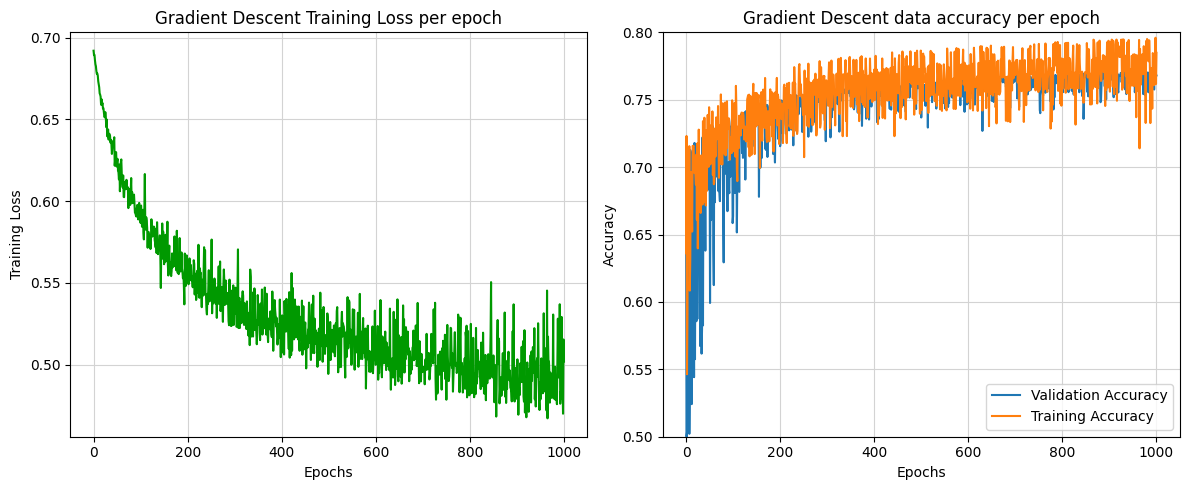

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(train_losses, color='#009900', label='Training Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Gradient Descent Training Loss per epoch')
axes[0].grid(color='lightgray')

axes[1].plot(val_accuracies, label='Validation Accuracy')
axes[1].plot(train_accuracies, label='Training Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.5, 0.8)
axes[1].set_title('Gradient Descent data accuracy per epoch')
axes[1].grid(color='lightgray')

plt.legend()
plt.tight_layout()
plt.show()

Testing with learning rate: 0.01
Testing with learning rate: 0.1
Testing with learning rate: 1
Testing with learning rate: 10
Testing with epochs: 100.0
Testing with epochs: 400.0
Testing with epochs: 700.0
Testing with epochs: 1000.0
Testing with batch size: 512
Testing with batch size: 5287
Testing with batch size: 10062
Testing with batch size: 14838


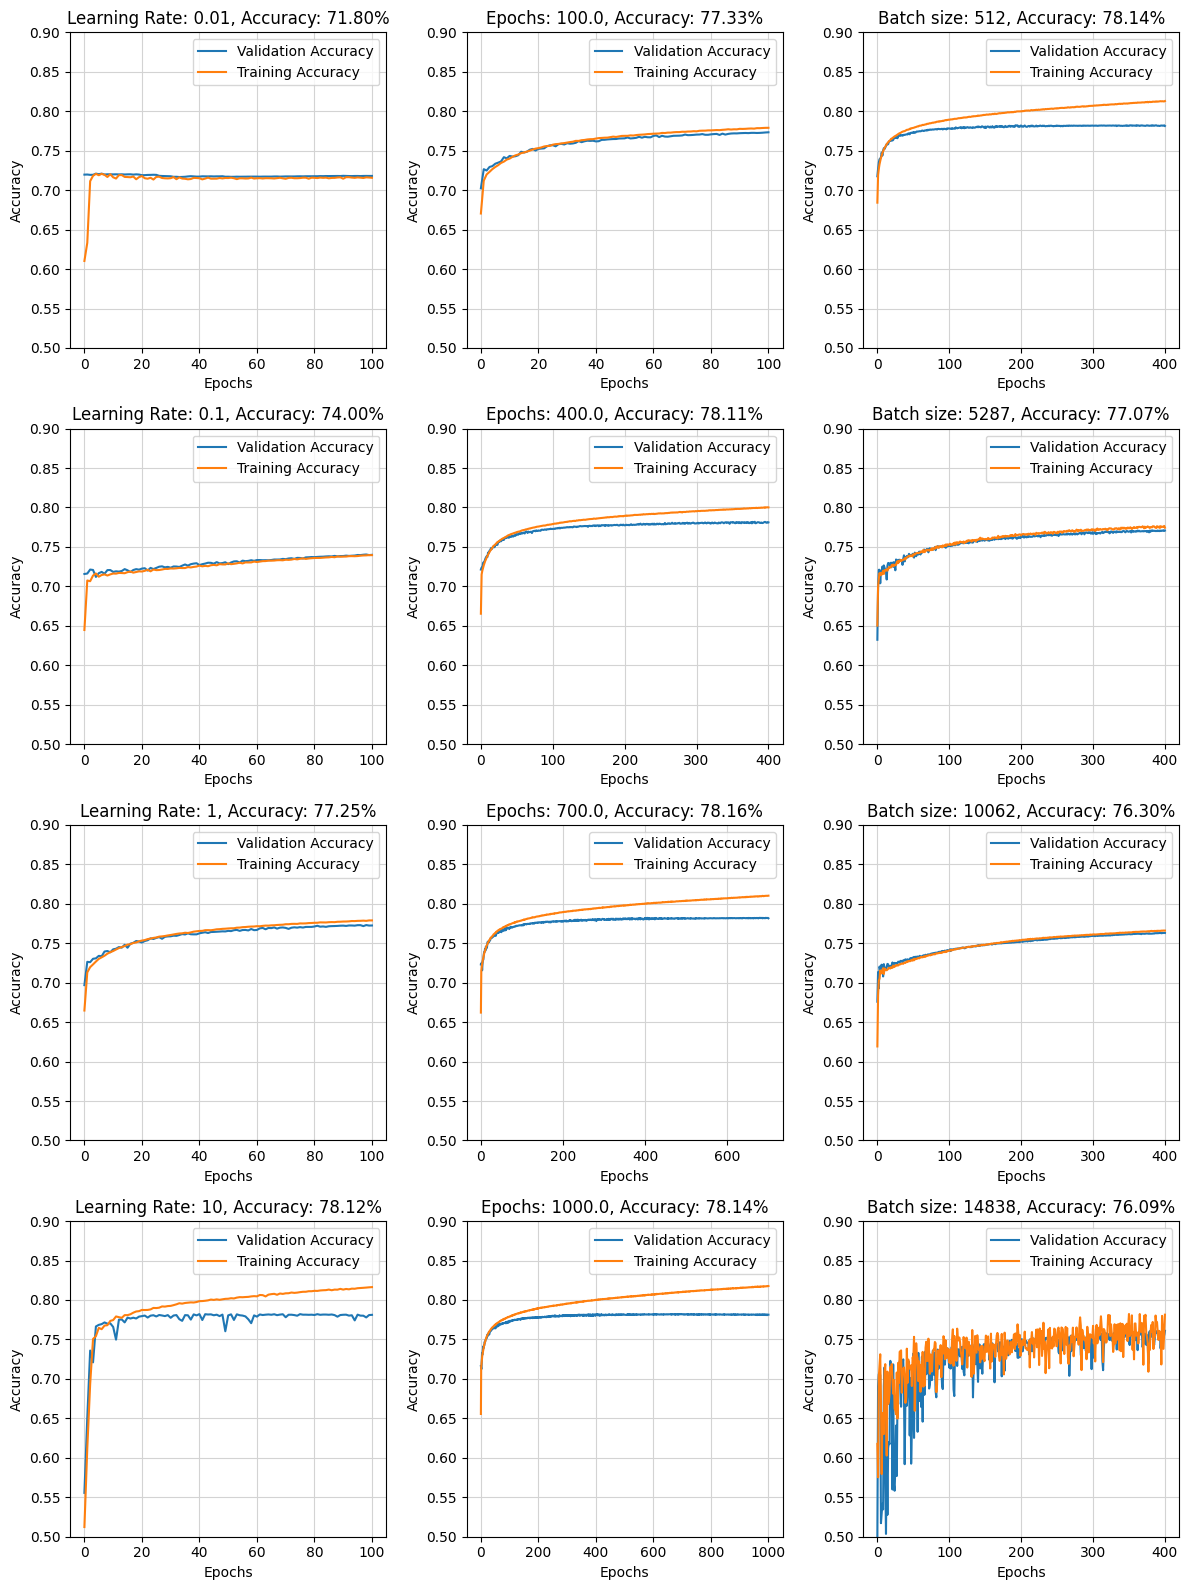

In [29]:
fig, axes = plt.subplots(4, 3, figsize=(12, 16))
learning_rates = [0.01, 0.1, 1, 10]
epochs = np.linspace(100, 1000, 4)
batch_sizes = np.linspace(512, 14838, 4)

for i, learning_rate in enumerate(learning_rates):
    print(f'Testing with learning rate: {learning_rate}')
    W, b, train_losses, train_accuracies, val_accuracies = GradientDescent(
        X_train, y_train.values.reshape(-1, 1), 
        X_val, y_val.values.reshape(-1, 1),
        learning_rate, 100, 1024,
        print_progress=False
    )
    
    y_pred = sigmoid(X_val @ W + b)
    y_pred = (y_pred >= 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)
    
    axes[i, 0].plot(val_accuracies, label='Validation Accuracy')
    axes[i, 0].plot(train_accuracies, label='Training Accuracy')
    axes[i, 0].set_xlabel('Epochs')
    axes[i, 0].set_ylabel('Accuracy')
    axes[i, 0].set_ylim(0.5, 0.9)
    axes[i, 0].set_title(f'Learning Rate: {learning_rate}, Accuracy: {accuracy*100:.2f}%')
    axes[i, 0].grid(color='lightgray')
    axes[i, 0].legend()
    
for i, epochs_value in enumerate(epochs):
    print(f'Testing with epochs: {epochs_value}')
    W, b, train_losses, train_accuracies, val_accuracies = GradientDescent(
        X_train, y_train.values.reshape(-1, 1), 
        X_val, y_val.values.reshape(-1, 1),
        1, int(epochs_value), 1024,
        print_progress=False
    )
    
    y_pred = sigmoid(X_val @ W + b)
    y_pred = (y_pred >= 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)
    
    axes[i, 1].plot(val_accuracies, label='Validation Accuracy')
    axes[i, 1].plot(train_accuracies, label='Training Accuracy')
    axes[i, 1].set_xlabel('Epochs')
    axes[i, 1].set_ylabel('Accuracy')
    axes[i, 1].set_ylim(0.5, 0.9)
    axes[i, 1].set_title(f'Epochs: {epochs_value}, Accuracy: {accuracy*100:.2f}%')
    axes[i, 1].grid(color='lightgray')
    axes[i, 1].legend()
    
for i, batch_size in enumerate(batch_sizes):
    print(f'Testing with batch size: {int(batch_size)}')
    W, b, train_losses, train_accuracies, val_accuracies = GradientDescent(
        X_train, y_train.values.reshape(-1, 1), 
        X_val, y_val.values.reshape(-1, 1),
        1, 400, int(batch_size),
        print_progress=False
    )
    
    y_pred = sigmoid(X_val @ W + b)
    y_pred = (y_pred >= 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)
    
    axes[i, 2].plot(val_accuracies, label='Validation Accuracy')
    axes[i, 2].plot(train_accuracies, label='Training Accuracy')
    axes[i, 2].set_xlabel('Epochs')
    axes[i, 2].set_ylabel('Accuracy')
    axes[i, 2].set_ylim(0.5, 0.9)
    axes[i, 2].set_title(f'Batch size: {int(batch_size)}, Accuracy: {accuracy*100:.2f}%')
    axes[i, 2].grid(color='lightgray')
    axes[i, 2].legend()
    
plt.tight_layout()
plt.show()

In [30]:
y_pred = sigmoid(X_test @ W + b)
y_pred = (y_pred >= 0.5).astype(int)

submission_df = pd.DataFrame({'ID': test_df['ID'], 'Label': y_pred.T[0]})
submission_df.to_csv('submission.csv', index=False)

### Base Model

#### Logistic Regression Definition
We will continue by creating the model on which the training procedure will be done. This of course is based on the **Logistic Regression**. We will also train our model using the train file.

In [31]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [32]:
# Predict the validation data and calculate the evaluation metrics and classification report
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

# Create a dataframe of the classification report
report_df = pd.DataFrame(classification_report(y_val, y_pred, output_dict=True)).T

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
report_df

Accuracy: 0.7819841494480612
Precision: 0.7775559476274492
Recall: 0.7899900938723524
F1 Score: 0.7837237054542902


,precision,recall,f1-score,support
0,0.786557,0.773977,0.780216,21197.000000
1,0.777556,0.789990,0.783724,21199.000000
accuracy,0.781984,0.781984,0.781984,0.781984
macro avg,0.782056,0.781984,0.781970,42396.000000
weighted avg,0.782056,0.781984,0.781970,42396.000000


#### Confusion Matrix
Let's compute and visualize the **confusion matrix** of the base model.

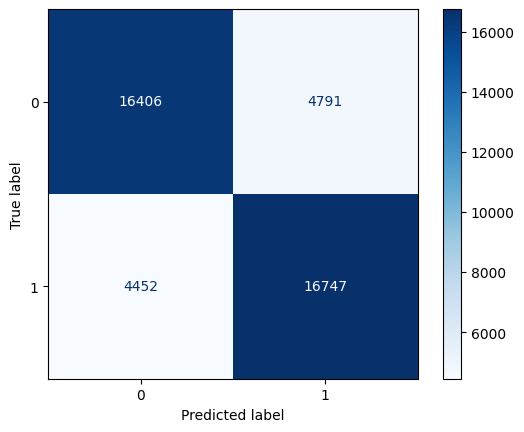

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_val, y_pred),
    display_labels=model.classes_
)
disp.plot(cmap="Blues")
plt.show()

#### Learning Curves & ROC Curve
Let's also extract the **learning curves** of the base model between the training and validating data, and the **ROC curve**.

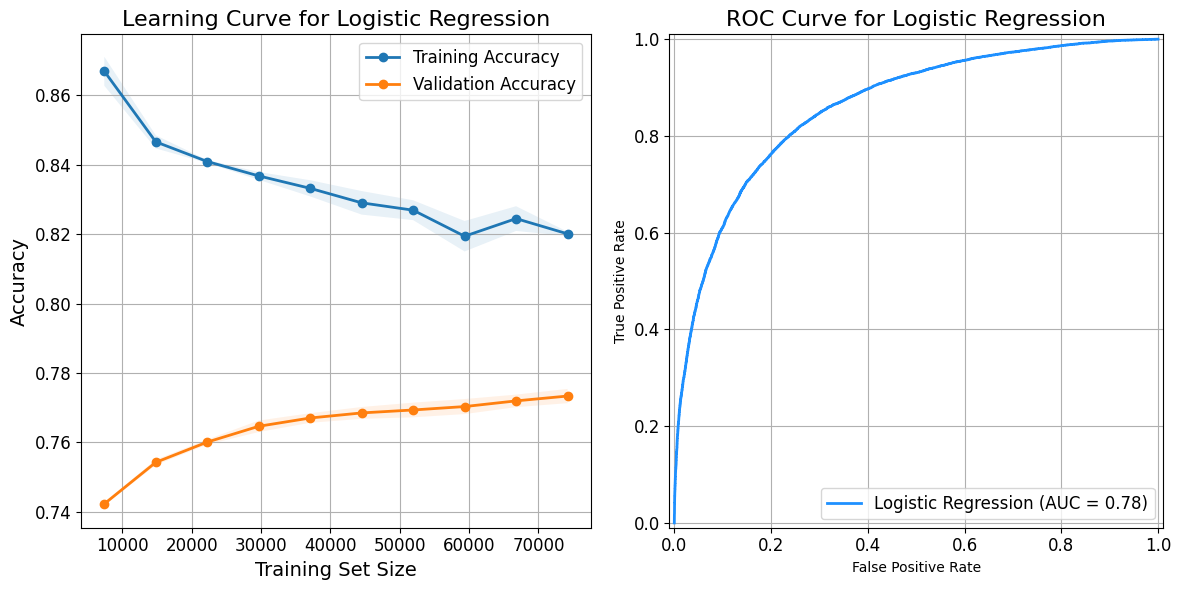

In [34]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, RocCurveDisplay

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=2, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and std deviation for shading
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(test_scores, axis=1)
val_std = np.std(test_scores, axis=1)

# Extract the ROC curve of the model
y_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

# Plot learning curves and ROC curve side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Learning Curve
axes[0].plot(train_sizes, train_mean, 'o-', label="Training Accuracy", linewidth=2)
axes[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
axes[0].plot(train_sizes, val_mean, 'o-', label="Validation Accuracy", linewidth=2)
axes[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
axes[0].set_xlabel("Training Set Size", fontsize=14)
axes[0].set_ylabel("Accuracy", fontsize=14)
axes[0].set_title("Learning Curve for Logistic Regression", fontsize=16)
axes[0].legend(fontsize=12)
axes[0].grid()
axes[0].tick_params(axis='both', which='major', labelsize=12)

# ROC Curve
roc_display = RocCurveDisplay(
    fpr=fpr, 
    tpr=tpr, 
    roc_auc=model.score(X_val, y_val), 
    estimator_name="Logistic Regression"
)
roc_display.plot(ax=axes[1], color='dodgerblue', linewidth=2)
axes[1].set_title("ROC Curve for Logistic Regression", fontsize=16)
axes[1].grid(True)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].legend(fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()


### Variable number of max features
We are now going to test different values for **max features** as a parameter for the **TF-IDF** vectorizer.

In [35]:
max_features_values = [value for value in range(1000, 100000, 1000)]

model = LogisticRegression()
accuracies, precissions, recalls, f1_scores = [], [], [], []

for i, value in enumerate(max_features_values):
    X_train, X_val, X_test, y_train, y_val, vectorizer = vectorize_data(train_df, val_df, test_df, value, None)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    accuracies.append(accuracy)
    precissions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    if i % 10 == 0:
        print(f"\rEpoch {i+1}/{int(100000/1000)}, Accuracy: {accuracy*100}%")

Epoch 1/100, Accuracy: 76.33974903292764%
Epoch 11/100, Accuracy: 78.07104443815454%
Epoch 21/100, Accuracy: 78.14652325691102%
Epoch 31/100, Accuracy: 78.16775167468629%
Epoch 41/100, Accuracy: 78.18662137937541%
Epoch 51/100, Accuracy: 78.18426266628927%
Epoch 61/100, Accuracy: 78.21964336258137%
Epoch 71/100, Accuracy: 78.2267195018398%
Epoch 81/100, Accuracy: 78.19841494480612%
Epoch 91/100, Accuracy: 78.19841494480612%


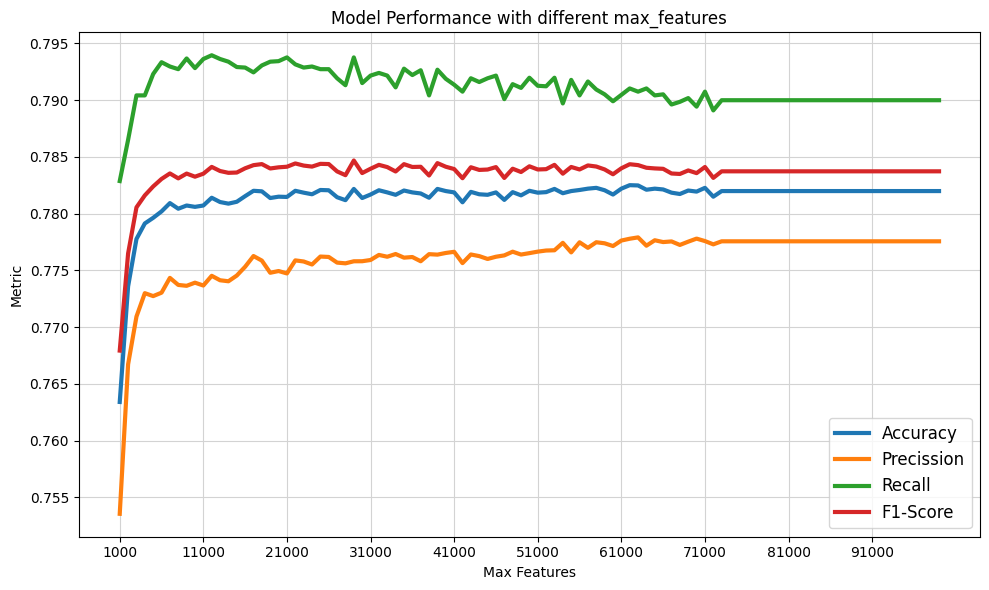

Best accuracy is 0.7825030663270119 and is received by using 62000 features.


In [36]:
plt.figure(figsize=(10, 6))
plt.plot(max_features_values, accuracies, label='Accuracy', linewidth=3)
plt.plot(max_features_values, precissions, label='Precission', linewidth=3)
plt.plot(max_features_values, recalls, label='Recall', linewidth=3)
plt.plot(max_features_values, f1_scores, label='F1-Score', linewidth=3)

plt.xticks([value for value in range(1000, 100000, 10000)])

plt.xlabel('Max Features')
plt.ylabel('Metric')
plt.title('Model Performance with different max_features')

plt.grid(color='lightgrey')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

accuracies_max_features = zip(accuracies, max_features_values)
max_accuracy, best_max_feature = max(accuracies_max_features, key=lambda pair: pair[0])

print(f"Best accuracy is {max_accuracy} and is received by using {best_max_feature} features.")

### Using n-grams
We will now use **n-grams** in our implementation and see if we can get any better results

In [37]:
ngrams_values = [value for value in range(2, 7, 1)]

model = LogisticRegression()
accuracies, precissions, recalls, f1_scores = [], [], [], []

for value in ngrams_values:
    X_train, X_val, X_test, y_train, y_val, vectorizer = vectorize_data(train_df, val_df, test_df, 63000, (1, value))

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    accuracies.append(accuracy)
    precissions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Current n-gram range: (1, {value}), Accuracy: {accuracy*100}%")

Current n-gram range: (1, 2), Accuracy: 79.6348712142655%
Current n-gram range: (1, 3), Accuracy: 79.87310123596566%
Current n-gram range: (1, 4), Accuracy: 79.88253608831022%
Current n-gram range: (1, 5), Accuracy: 79.74808944240023%
Current n-gram range: (1, 6), Accuracy: 79.83064440041512%


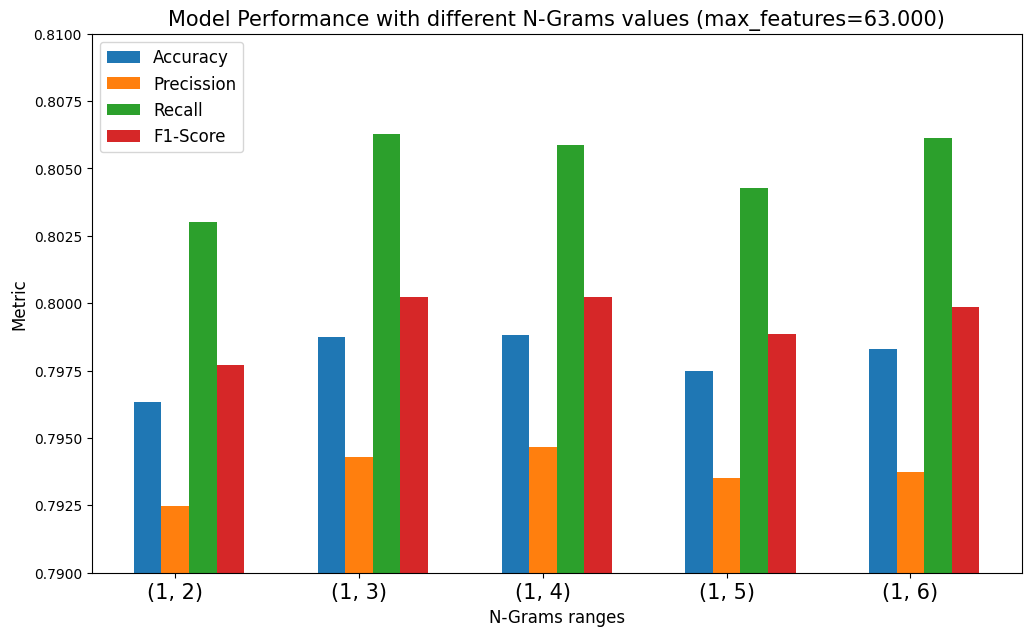

Best accuracy is 0.7988253608831022 and is received by using (1, 4) as an N-Gram range.


In [38]:
import matplotlib.pyplot as plt
import numpy as np

labels = [f'(1, {value})' for value in ngrams_values]
data = {
    'Accuracy': accuracies,
    'Precission': precissions,
    'Recall': recalls,
    'F1-Score': f1_scores
}

x = np.arange(len(labels))
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 7))

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_xlabel('N-Grams ranges', fontsize=12)
ax.set_ylabel('Metric', fontsize=12)
ax.set_title('Model Performance with different N-Grams values (max_features=63.000)', fontsize=15)
ax.set_xticks(x + width, labels, fontsize=15)
ax.legend(fontsize=12)
ax.set_ylim(0.79, 0.81)

plt.show()

accuracies_ngrams = zip(accuracies, ngrams_values)
max_accuracy, best_ngram_value = max(accuracies_ngrams, key=lambda pair: pair[0])

print(f"Best accuracy is {max_accuracy} and is received by using (1, {best_ngram_value}) as an N-Gram range.")

### Combining max_features and n-grams
We will now experiment with different values of max_features and (1, 4) as an n-grams range

In [39]:
X_train, X_val, X_test, y_train, y_val, vectorizer = vectorize_data(train_df, val_df, test_df, None, (1, 4))

print(X_train.shape, X_val.shape)

(148388, 2481903) (42396, 2481903)


In [40]:
max_features_values = [value for value in range(1000, 2_482_000, 100_000)]

model = LogisticRegression()
accuracies, precissions, recalls, f1_scores = [], [], [], []

for i, value in enumerate(max_features_values):
    X_train, X_val, X_test, y_train, y_val, vectorizer = vectorize_data(train_df, val_df, test_df, value, (1,4))
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    accuracies.append(accuracy)
    precissions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    if i % 5 == 0:
        print(f"\rEpoch {i+1}/{int(2_482_000/100_000)}, Accuracy: {accuracy*100}%")

Epoch 1/24, Accuracy: 76.49306538352675%
Epoch 6/24, Accuracy: 79.81177469572602%
Epoch 11/24, Accuracy: 79.55467496933673%
Epoch 16/24, Accuracy: 79.47212001132182%
Epoch 21/24, Accuracy: 79.43202188885743%


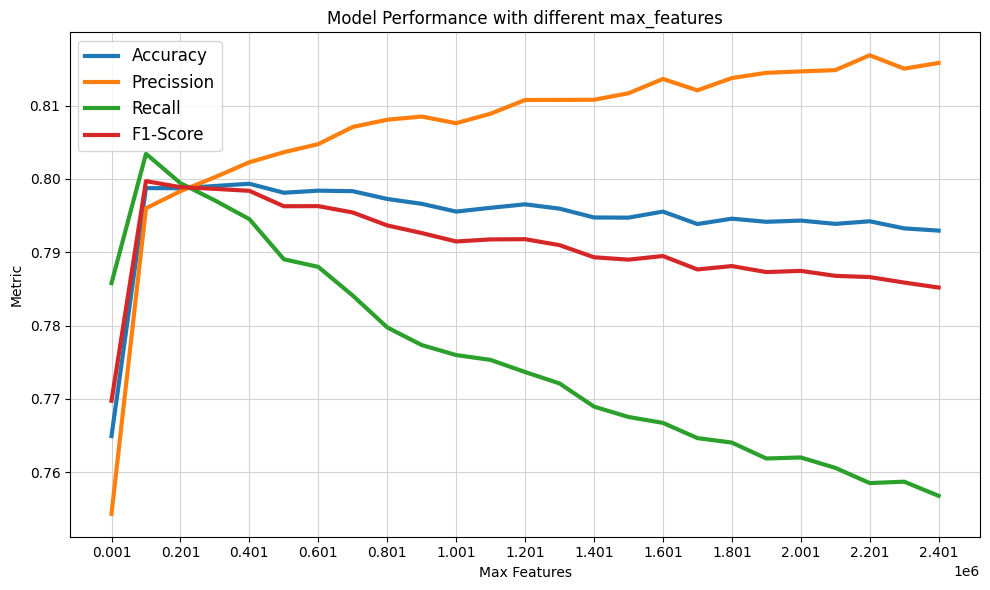

Best accuracy is 0.7993442777620531 and is received by using 401000 features.


In [41]:
plt.figure(figsize=(10, 6))
plt.plot(max_features_values, accuracies, label='Accuracy', linewidth=3)
plt.plot(max_features_values, precissions, label='Precission', linewidth=3)
plt.plot(max_features_values, recalls, label='Recall', linewidth=3)
plt.plot(max_features_values, f1_scores, label='F1-Score', linewidth=3)

plt.xticks([value for value in range(1000, 2_482_000, 200_000)])

plt.xlabel('Max Features')
plt.ylabel('Metric')
plt.title('Model Performance with different max_features')

plt.grid(color='lightgrey')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

accuracies_max_features = zip(accuracies, max_features_values)
max_accuracy, best_max_feature = max(accuracies_max_features, key=lambda pair: pair[0])

print(f"Best accuracy is {max_accuracy} and is received by using {best_max_feature} features.")

We will also check if there is overfitting in our model.

In [42]:
X_train, X_val, X_test, y_train, y_val, vectorizer = vectorize_data(train_df, val_df, test_df, 401_000, (1,4))

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

0.7993442777620531


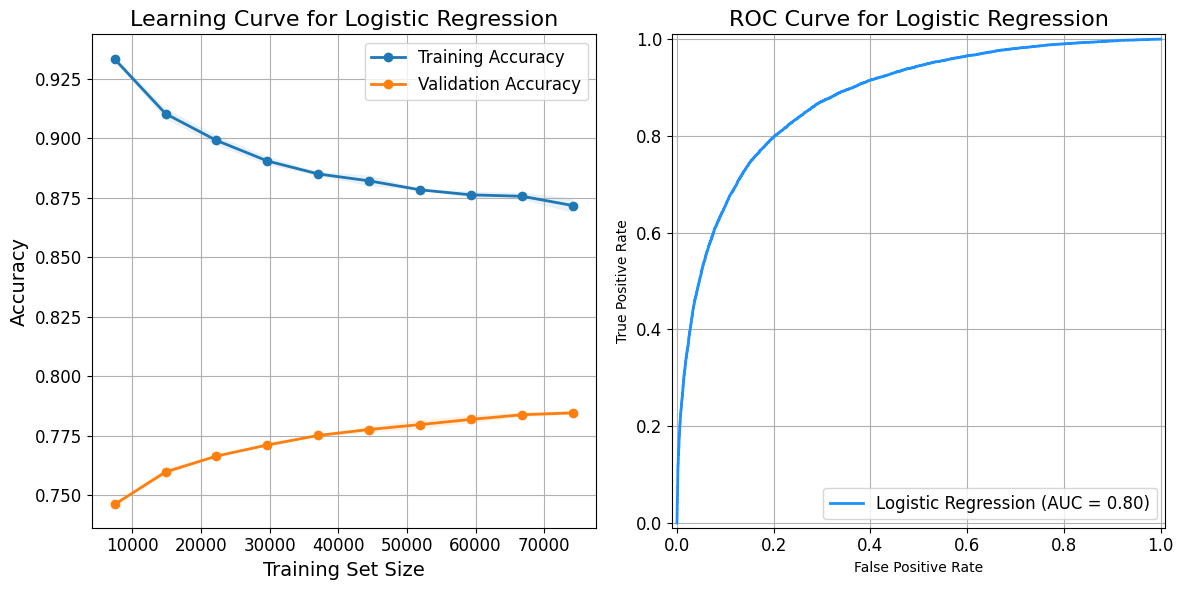

In [43]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, RocCurveDisplay

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=2, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and std deviation for shading
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(test_scores, axis=1)
val_std = np.std(test_scores, axis=1)

# Extract the ROC curve of the model
y_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

# Plot learning curves and ROC curve side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Learning Curve
axes[0].plot(train_sizes, train_mean, 'o-', label="Training Accuracy", linewidth=2)
axes[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
axes[0].plot(train_sizes, val_mean, 'o-', label="Validation Accuracy", linewidth=2)
axes[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
axes[0].set_xlabel("Training Set Size", fontsize=14)
axes[0].set_ylabel("Accuracy", fontsize=14)
axes[0].set_title("Learning Curve for Logistic Regression", fontsize=16)
axes[0].legend(fontsize=12)
axes[0].grid()
axes[0].tick_params(axis='both', which='major', labelsize=12)

# ROC Curve
roc_display = RocCurveDisplay(
    fpr=fpr, 
    tpr=tpr, 
    roc_auc=model.score(X_val, y_val), 
    estimator_name="Logistic Regression"
)
roc_display.plot(ax=axes[1], color='dodgerblue', linewidth=2)
axes[1].set_title("ROC Curve for Logistic Regression", fontsize=16)
axes[1].grid(True)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].legend(fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()


### Logistic Regression solvers, C values and penalties

In [44]:
solvers = ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg']

for solver in solvers:
    model = LogisticRegression(solver=solver)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"Current solver: {solver}, Accuracy: {accuracy*100}%")

Current solver: lbfgs, Accuracy: 79.93442777620531%
Current solver: liblinear, Accuracy: 79.93442777620531%
Current solver: sag, Accuracy: 79.93442777620531%
Current solver: saga, Accuracy: 79.93442777620531%
Current solver: newton-cg, Accuracy: 79.93442777620531%


In [45]:
c_values = np.linspace(0.01, 1, 10)

for c in c_values:
    model = LogisticRegression(solver='liblinear', C=c)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"Current C: {c}, Accuracy: {accuracy*100}%")

Current C: 0.01, Accuracy: 79.93442777620531%
Current C: 0.12, Accuracy: 79.93442777620531%
Current C: 0.23, Accuracy: 79.93442777620531%
Current C: 0.34, Accuracy: 79.93442777620531%
Current C: 0.45, Accuracy: 79.93442777620531%
Current C: 0.56, Accuracy: 79.93442777620531%
Current C: 0.67, Accuracy: 79.93442777620531%
Current C: 0.78, Accuracy: 79.93442777620531%
Current C: 0.89, Accuracy: 79.93442777620531%
Current C: 1.0, Accuracy: 79.93442777620531%


In [46]:
penalties = ['l1', 'l2']

for penalty in penalties:
    model = LogisticRegression(solver='liblinear', penalty=penalty)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"Current Penalty: {penalty}, Accuracy: {accuracy*100}%")

Current Penalty: l1, Accuracy: 79.93442777620531%
Current Penalty: l2, Accuracy: 79.93442777620531%


In [47]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': np.linspace(0.01, 1, 10),
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg']
}

# Initialize the data and the model
model = LogisticRegression()
X_train, X_val, X_test, y_train, y_val, vectorizer = vectorize_data(train_df, val_df, test_df, 401_000, (1,4))

# Initialize Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, verbose=1, scoring='accuracy', n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Train the model with the best parameters
best_model = LogisticRegression(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_val)
accuacy = accuracy_score(y_val, y_pred)
print(accuracy)

Fitting 2 folds for each of 200 candidates, totalling 400 fits
Best Parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Cross-Validation Score: 0.7848208750033696
0.7993442777620531


In [48]:
results_df = pd.DataFrame(grid_search.cv_results_)

results_df = results_df[
    ['mean_test_score', 'std_test_score', 'params']
].sort_values(by='mean_test_score', ascending=False)

results_df.head(10)

,mean_test_score,std_test_score,params
189,0.784821,0.001173,"{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-..."
188,0.784720,0.001098,"{'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}"
187,0.784700,0.001092,"{'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}"
186,0.784700,0.001092,"{'C': 1.0, 'penalty': 'l2', 'solver': 'libline..."
185,0.784632,0.000849,"{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}"
165,0.784396,0.001408,"{'C': 0.89, 'penalty': 'l2', 'solver': 'lbfgs'}"
169,0.784167,0.001220,"{'C': 0.89, 'penalty': 'l2', 'solver': 'newton..."
167,0.784053,0.001011,"{'C': 0.89, 'penalty': 'l2', 'solver': 'sag'}"
166,0.784039,0.000997,"{'C': 0.89, 'penalty': 'l2', 'solver': 'liblin..."
168,0.784026,0.001011,"{'C': 0.89, 'penalty': 'l2', 'solver': 'saga'}"


### Redefinition of the clean function

In [50]:
def clean_text(text: str) -> str:
    text = text.lower() # Convert to lowercase
    text = contractions.fix(text) # Expand contractions
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # Remove url links
    text = re.sub(r"@\w+", "", text) # Remove mentions
    text = re.sub(r"#(\w+)", "", text) # Remove hastags
    text = re.sub(r"(?<!\.)\.(?!\.)|[^\w\s\?\!]", "", text)
    text = re.sub(r"\.\.\.", " ... ", text)  # Ensure '...' is treated as a single token
    
    text = re.sub(r"&[^;\s]+;", "", text) # Remove special characters
    text = re.sub(r"\s+", " ", text) # Remove extra spaces
    
    text = re.sub(r"\d+", "", text)
    
    return text

train_df["Cleaned_text"] = train_df["Text"].apply(clean_text)
val_df["Cleaned_text"] = val_df["Text"].apply(clean_text)
test_df["Cleaned_text"] = test_df["Text"].apply(clean_text)

X_train, X_val, X_test, y_train, y_val, vectorizer = vectorize_data(train_df, val_df, test_df, 401000, (1,4))

#### Executing Gradient Descent again

In [55]:
W, b, train_losses, train_accuracies, val_accuracies = GradientDescent(
    X_train, y_train.values.reshape(-1, 1), 
    X_val, y_val.values.reshape(-1, 1),
    1, 1000, 512
)

# Final evaluation
y_pred = sigmoid(X_val @ W + b)
y_pred = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_val, y_pred)
print(f'Final Validation Accuracy: {accuracy*100:.2f}%')

Epoch 1, Loss: 0.6680722573881389 Training Accuracy: 71.05% Validation Accuracy: 72.75%
Epoch 100, Loss: 0.4555683706014075 Training Accuracy: 80.84% Validation Accuracy: 78.59%
Epoch 200, Loss: 0.4132750288956121 Training Accuracy: 83.09% Validation Accuracy: 79.54%
Epoch 300, Loss: 0.3860930420288914 Training Accuracy: 84.70% Validation Accuracy: 80.04%
Epoch 400, Loss: 0.3653016400351307 Training Accuracy: 85.92% Validation Accuracy: 80.26%
Epoch 500, Loss: 0.34809851972068573 Training Accuracy: 86.97% Validation Accuracy: 80.37%
Epoch 600, Loss: 0.3332846419045395 Training Accuracy: 87.82% Validation Accuracy: 80.41%
Epoch 700, Loss: 0.320263317507521 Training Accuracy: 88.62% Validation Accuracy: 80.43%
Epoch 800, Loss: 0.3085702480270144 Training Accuracy: 89.32% Validation Accuracy: 80.46%
Epoch 900, Loss: 0.29799618308755654 Training Accuracy: 89.94% Validation Accuracy: 80.48%
Epoch 1000, Loss: 0.2883278402562391 Training Accuracy: 90.52% Validation Accuracy: 80.50%
Final Vali

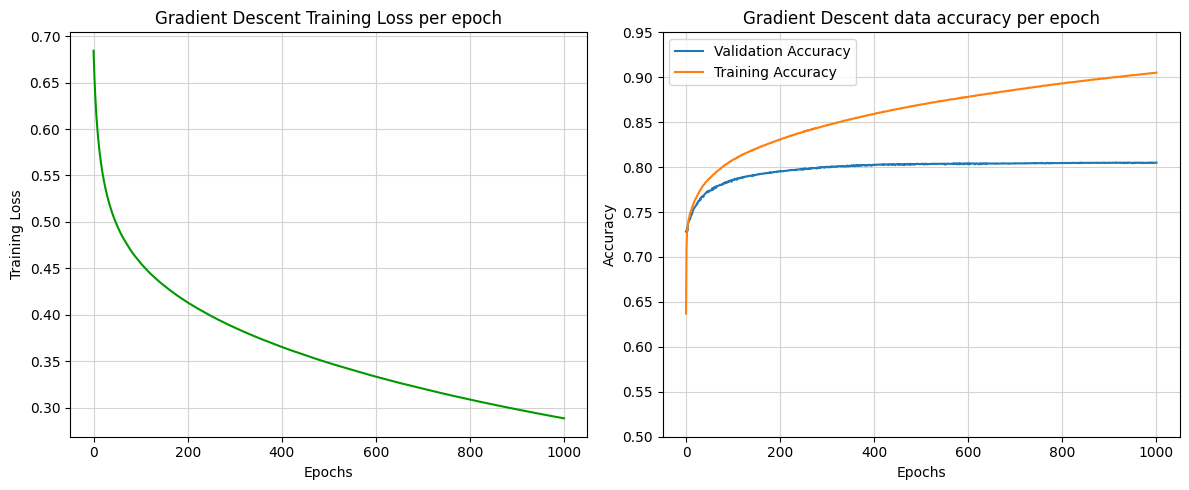

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(train_losses, color='#009900', label='Training Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Gradient Descent Training Loss per epoch')
axes[0].grid(color='lightgray')

axes[1].plot(val_accuracies, label='Validation Accuracy')
axes[1].plot(train_accuracies, label='Training Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.5, 0.95)
axes[1].set_title('Gradient Descent data accuracy per epoch')
axes[1].grid(color='lightgray')

plt.legend()
plt.tight_layout()
plt.show()

#### Executing Scikit-Learn Logistic Regression again

In [73]:
model = LogisticRegression(**best_params)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy}')

y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f'Training Accuracy: {accuracy}')

Validation Accuracy: 0.802103972072837
Training Accuracy: 0.8704544841900962


In [77]:
y_pred = sigmoid(X_test @ W + b)
predictions = (y_pred >= 0.5).astype(int)

print(predictions.shape)

submission_df = pd.DataFrame({'ID': test_df['ID'], 'Label': predictions.flatten()})
submission_df.to_csv('submission.csv', index=False)
submission_df

(21199, 1)


,ID,Label
0,102388,1
1,153802,0
2,61831,1
3,18317,1
4,50061,1
...,...,...
21194,101544,0
21195,5461,0
21196,135996,1
21197,157554,1


### Custom text testing

In [138]:
text_samples = [
    "I love this product! It's amazing and I'm so happy with it!",
    "OMG! I can't believe how bad this product is! I'm so disappointed!",
    "This is a good product, but it's not the best I've seen.",
    "This product is not good, I'm not happy with it.",
    "I can't imagine anyone buying this product...",
    "So overrated!",
    "Give me my money back!",
    "Just terrible...",
    "Am I the only one that doesn't find this interesting?",
    "Really? 200 dollars for this?",
    "ten out of ten!",
    "Who even finds this interesting? XD",
    "Totally worth buying it",
    "Wish I could turn back time and prevent myself from buying this"
]

cleaned_texts = [clean_text(text) for text in text_samples]
vectorized_texts = vectorizer.transform(cleaned_texts)

predictions = model.predict(vectorized_texts)
for i, prediction in enumerate(predictions):
    print(f"{text_samples[i]} ---> {'Positive' if prediction == 1 else 'Negative'}")

I love this product! It's amazing and I'm so happy with it! ---> Positive
OMG! I can't believe how bad this product is! I'm so disappointed! ---> Negative
This is a good product, but it's not the best I've seen. ---> Positive
This product is not good, I'm not happy with it. ---> Negative
I can't imagine anyone buying this product... ---> Negative
So overrated! ---> Positive
Give me my money back! ---> Negative
Just terrible... ---> Negative
Am I the only one that doesn't find this interesting? ---> Negative
Really? 200 dollars for this? ---> Negative
ten out of ten! ---> Negative
Who even finds this interesting? XD ---> Positive
Totally worth buying it ---> Positive
Wish I could turn back time and prevent myself from buying this ---> Negative
